# Stock Portfolio Optimization

## Background

Asset allocation is the most important decision that any investor needs to face. They need to decide how to spread their total capital over certain assets (in this case, stocks). When considering the allocation, the investor wants to balance the risk and the potential reward. At the same time, the allocation depends on factors such as individual goals, risk tolerance, and the investment horizon.

The key framework used in asset allocation is the Modern Portfolio Theory (MPT), which was introduced by the Nobel Prize winner Harry Markowitz. MPT describes how investors can construct portfolios to maximize their expected returns for a given level of risk or, conversely, minimize risk for a given level of expected return. The mathematical framework used to achieve this is called mean-variance optimization.

The main insight from MPT is that investors should not evaluate an asset’s performance alone. Instead, they should evaluate how it would impact the performance of a portfolio of assets. Another important takeaway is the concept of diversification, which means that owning different kinds of assets reduces risk. That is because the loss or gain of a particular security has less impact on the overall portfolio’s performance.


## Instructions

Use the `faang_stocks.csv` dataset to complete the following analysis:

* What are the expected returns and the annualized Sharpe ratio of an equally-weighted portfolio? Assume the risk-free rate is 0% and store your answers as a float variables called benchmark_exp_return and benchmark_sharpe_ratio.

* Find a portfolio that minimizes volatility. Use mean-variance optimization. Store the volatility of the portfolio as a float variable called mv_portfolio_vol. Store the portfolio weights as a pandas Series called mv_portfolio. Use the tickers as index.

* Find a portfolio that maximizes the Sharpe ratio. Use mean-variance optimization and keep the risk-free rate at 0%. Store the Sharpe ratio (annualized) of the portfolio as a float variable called ms_portfolio_sharpe. Store the portfolio weights as a pandas Series called ms_portfolio. Use the tickers as index.

<br>

In the dynamic realm of finance, data scientists/analysts are often tasked with finding optimal investment strategies. Imagine you're one such analyst, and you were asked to build an effective portfolio comprising FAANG stocks – Facebook (Meta), Apple, Amazon, Netflix, and Google. The goal is to maximize returns while mitigating risk.

You are tasked to find the optimal allocation to the FAANG stocks based on historical stock price data spanning the years 2020-2023. The dataset is stored in the `faang_stocks.csv` file. For each trading day, it contains the close prices of the five tech companies.

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Helps optimize stock portfolios.
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import scipy.optimize as sco

In [88]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [89]:
# Setting the plotting style to be colorblind-friendly
# plt.style.use("seaborn-v0_8-colorblind")
# plt.style.use("dark_background")
plt.style.use("seaborn-v0_8-dark-palette")

In [90]:
# Loading data
# stock_prices_df = pd.read_csv("../data_raw/faang_stocks.csv", index_col="Date")
stock_prices_df = pd.read_csv("../data_raw/faang_stocks.csv")
stock_prices_df

,Date,AAPL,AMZN,GOOGL,META,NFLX
0,2020-01-02,75.09,94.90,68.43,209.78,329.81
1,2020-01-03,74.36,93.75,68.08,208.67,325.90
2,2020-01-06,74.95,95.14,69.89,212.60,335.83
3,2020-01-07,74.60,95.34,69.76,213.06,330.75
4,2020-01-08,75.80,94.60,70.25,215.22,339.26
...,...,...,...,...,...,...
1001,2023-12-22,193.60,153.42,141.49,353.39,486.76
1002,2023-12-26,193.05,153.41,141.52,354.83,491.19
1003,2023-12-27,193.15,153.34,140.37,357.83,491.79
1004,2023-12-28,193.58,153.38,140.23,358.32,490.51


Each row shows the daily closing price for FAANG stocks.    
On 2020-01-02, Apple’s stock closed at $75.09, Amazon at $94.90, etc.

In [91]:
stock_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1006 non-null   object 
 1   AAPL    1006 non-null   float64
 2   AMZN    1006 non-null   float64
 3   GOOGL   1006 non-null   float64
 4   META    1006 non-null   float64
 5   NFLX    1006 non-null   float64
dtypes: float64(5), object(1)
memory usage: 47.3+ KB


In [92]:
# # Changing the index to a datetime type allows for easier filtering and plotting.
# stock_prices_df.index = pd.to_datetime(stock_prices_df.index)
# stock_prices_df

In [93]:
# Changing the index to a datetime type allows for easier filtering and plotting.
stock_prices_df['Date'] = pd.to_datetime(stock_prices_df['Date'])
stock_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1006 non-null   datetime64[ns]
 1   AAPL    1006 non-null   float64       
 2   AMZN    1006 non-null   float64       
 3   GOOGL   1006 non-null   float64       
 4   META    1006 non-null   float64       
 5   NFLX    1006 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 47.3 KB


In [54]:
stock_prices_df.set_index('Date', inplace=True)
stock_prices_df

,AAPL,AMZN,GOOGL,META,NFLX
Date,,,,,
2020-01-02,75.09,94.90,68.43,209.78,329.81
2020-01-03,74.36,93.75,68.08,208.67,325.90
2020-01-06,74.95,95.14,69.89,212.60,335.83
2020-01-07,74.60,95.34,69.76,213.06,330.75
2020-01-08,75.80,94.60,70.25,215.22,339.26
...,...,...,...,...,...
2023-12-22,193.60,153.42,141.49,353.39,486.76
2023-12-26,193.05,153.41,141.52,354.83,491.19
2023-12-27,193.15,153.34,140.37,357.83,491.79


In [48]:
stock_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2020-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1006 non-null   float64
 1   AMZN    1006 non-null   float64
 2   GOOGL   1006 non-null   float64
 3   META    1006 non-null   float64
 4   NFLX    1006 non-null   float64
dtypes: float64(5)
memory usage: 47.2 KB


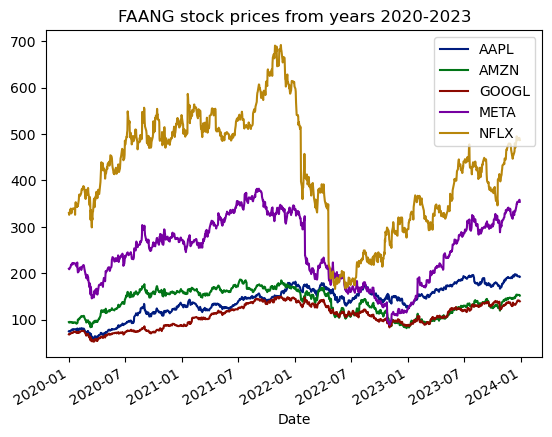

In [55]:
# Plotting the stock prices
stock_prices_df.plot(title="FAANG stock prices from years 2020-2023");

### Calculating Stock Returns

In [56]:
### Task 1 ---------------------------------------------------

### Calculate returns
# .pct_change() -> Calculates daily percentage changes in stock prices.
# .dropna() -> Removes any rows with missing values.

returns_df = stock_prices_df.pct_change().dropna()
returns_df

,AAPL,AMZN,GOOGL,META,NFLX
Date,,,,,
2020-01-03,-0.009722,-0.012118,-0.005115,-0.005291,-0.011855
2020-01-06,0.007934,0.014827,0.026586,0.018834,0.030469
2020-01-07,-0.004670,0.002102,-0.001860,0.002164,-0.015127
2020-01-08,0.016086,-0.007762,0.007024,0.010138,0.025729
2020-01-09,0.021240,0.004757,0.010534,0.014311,-0.010611
...,...,...,...,...,...
2023-12-22,-0.005548,-0.002730,0.007620,-0.001977,-0.009866
2023-12-26,-0.002841,-0.000065,0.000212,0.004075,0.009101
2023-12-27,0.000518,-0.000456,-0.008126,0.008455,0.001222


On 2020-01-03, Apple’s stock dropped by -0.97%, Amazon dropped by -1.21%, etc.   
On 2020-01-06, Apple gained +0.79%, Amazon gained +1.48%, etc.   

### Calculating Equal-Weighted Portfolio Returns

In [94]:
### Calculate the 1/n portfolio weights

# Creates an equal allocation of 20% in each stock.
portfolio_weights = 5 * [0.2]
portfolio_weights

[0.2, 0.2, 0.2, 0.2, 0.2]

In [58]:
### Calculate the portfolio returns of the 1/n portfolio

# .dot() to calculate the total daily return for the portfolio
portfolio_returns = returns_df.dot(portfolio_weights)
portfolio_returns

Date
2020-01-03   -0.008820
2020-01-06    0.019730
2020-01-07   -0.003478
2020-01-08    0.010243
2020-01-09    0.008046
                ...   
2023-12-22   -0.002500
2023-12-26    0.002096
2023-12-27    0.000322
2023-12-28    0.000051
2023-12-29   -0.007646
Length: 1005, dtype: float64

On 2020-01-03, the portfolio lost -0.88%.   
On 2020-01-06, the portfolio gained +1.97%.

### Calculating Portfolio Performance

Mean return → Computes average daily return of the portfolio.   
Expected Return → The portfolio earns ~0.0937% per day on average.

In [60]:
# Calculate the expected portfolio return
benchmark_exp_return = portfolio_returns.mean()
benchmark_exp_return

0.0009366970530650013

Sharpe Ratio → Measures how much return we get per unit of risk.   
Sharpe Ratio (0.722) → A higher number means better risk-adjusted returns.

In [61]:
# Calculate the portfolio's Sharpe ratio
benchmark_sharpe_ratio = (
    portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)
)
benchmark_sharpe_ratio

0.7221868020795008

In [62]:
# Task 2 ---------------------------------------------------

### Calculate the annualized expected returns

# returns_df.mean() → Calculates the average daily return for each stock.
# Multiplies by 252 trading days in a year to convert daily returns into annualized returns.
avg_returns = returns_df.mean() * 252
avg_returns

AAPL     0.292454
AMZN     0.188956
GOOGL    0.235250
META     0.242660
NFLX     0.220919
dtype: float64

This tells us how much we expect each stock to grow annually.  
      
    Higher is better, but must be balanced with risk.   
    The optimizer uses these values to find the best mix of stocks that maximize return while controlling risk.


- Apple’s expected return is ~29.24% per year.
- Amazon’s expected return is ~18.89% per year.
- Google, Meta, and Netflix have returns between ~22-24% per year.

In [63]:
### Calculate the covariance matrix

# returns_df.cov() → Calculates the daily covariance matrix, which shows how stocks move together.
# Multiplies by 252 trading days in a year to convert daily covariance into annualized covariance.
cov_mat = returns_df.cov() * 252
cov_mat

,AAPL,AMZN,GOOGL,META,NFLX
AAPL,0.112683,0.078926,0.077773,0.095367,0.077774
AMZN,0.078926,0.142040,0.083945,0.108089,0.101851
GOOGL,0.077773,0.083945,0.112423,0.106969,0.076233
META,0.095367,0.108089,0.106969,0.218838,0.116967
NFLX,0.077774,0.101851,0.076233,0.116967,0.237020


The diagonal values (e.g., AAPL: 0.1127, AMZN: 0.1420, etc.) represent the variance of each stock (how volatile it is).   
The off-diagonal values (e.g., AAPL-AMZN: 0.0789, GOOGL-NFLX: 0.0762, etc.) represent covariances, which measure how stocks move together.   

    If two stocks move together (high covariance), they don’t reduce risk much when combined.   
	If two stocks move oppositely (low or negative covariance), they help diversify and lower portfolio risk.   
	The optimizer uses this matrix to find the best combination of stocks that minimize risk.   

### Minimum Volatility Portfolio

Finds the stock allocation that minimizes risk.   
Stores the optimal stock weights and volatility.   

In [96]:
# Instantiate the EfficientFrontier object
ef = EfficientFrontier(avg_returns, cov_mat)

# Find the weights that maximize the Sharpe ratio
weights = ef.min_volatility()
mv_portfolio = pd.Series(weights)
mv_portfolio

AAPL     0.398420
AMZN     0.149108
GOOGL    0.382898
META     0.000000
NFLX     0.069574
dtype: float64

In [69]:
# Find the minimized volatility
mv_portfolio_vol = ef.portfolio_performance(risk_free_rate=0)[1]
mv_portfolio_vol

0.30307367115474626

The lowest-risk portfolio invests 40% in Apple, 38% in Google, and 15% in Amazon.   
Meta (0%) is excluded because it adds too much risk.   
The portfolio has 30.3% annual volatility.   


In [100]:
# # Task 2 - alternative solution ----------------------------

# # Calculate the annualized expected returns and the covariance matrix
# avg_returns = returns_df.mean() * 252
# cov_mat = returns_df.cov() * 252


# # Define the function to find the portfolio volatility using the weights and the covariance matrix
# def get_portfolio_volatility(weights, cov_mat):
#     return np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))
  
# # Define the number of assets
# n_assets = len(avg_returns)
# n_assets


# # Define the bounds - the weights can be between 0 and 1
# bounds = tuple((0, 1) for asset in range(n_assets))
# bounds


# # Define the initial guess - the equally weighted portfolio
# initial_guess = n_assets * [1.0 / n_assets]
# initial_guess


# # Define the constraint - all weights must add up to 1
# constr = {"type": "eq", "fun": lambda x: np.sum(x) - 1}
# constr



# # Find the minimum volatility portfolio
# result = sco.minimize(
#     get_portfolio_volatility,
#     x0=initial_guess,
#     args=cov_mat,
#     method="SLSQP",
#     constraints=constr,
#     bounds=bounds,
# )
# result



# # Store the portfolio weights
# mv_portfolio = pd.Series(result.x, index=avg_returns.index).round(2)
# mv_portfolio



# # Store the portfolio's volatility
# mv_portfolio_vol = result.fun
# mv_portfolio_vol

### Maximum Sharpe Ratio Portfolio

Finds the stock allocation that maximizes return per unit of risk.

In [98]:
# Task 3 ---------------------------------------------------

# Alternative approach to get the expected returns and the covariance matrix
# avg_returns = expected_returns.mean_historical_return(stock_prices_df, compounding=False)
# cov_mat = risk_models.sample_cov(stock_prices_df)

# Instantiate the EfficientFrontier object
ef = EfficientFrontier(avg_returns, cov_mat)
# Find the weights that maximize the Sharpe ratio
weights = ef.max_sharpe(risk_free_rate=0)
ms_portfolio = pd.Series(weights)
ms_portfolio

AAPL     0.787440
AMZN     0.000000
GOOGL    0.199698
META     0.000000
NFLX     0.012861
dtype: float64

In [86]:
# Find the maximized Sharpe ratio
ms_portfolio_sharpe = ef.portfolio_performance(risk_free_rate=0)[2]
ms_portfolio_sharpe

0.8821809421501474

This portfolio heavily favors Apple (78.7%) because it gives the best return per risk.   
Amazon & Meta get 0% because they don’t improve the risk-return tradeoff.   
The Sharpe Ratio is 0.882, meaning this is the best portfolio for maximizing returns with controlled risk.   

### Data Visualization

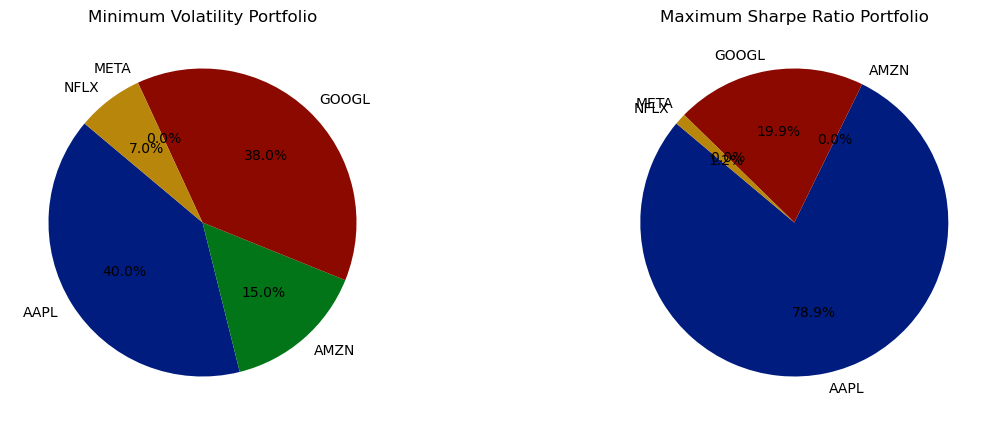

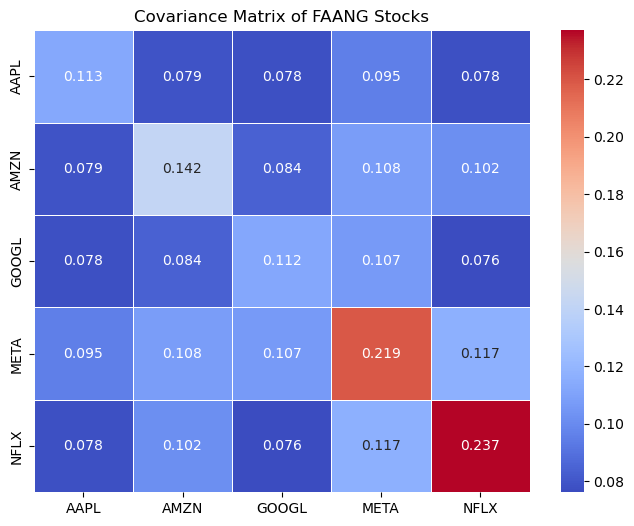

In [103]:
# Expected returns and covariance matrix (example values)
avg_returns = pd.Series({
    'AAPL': 0.2924, 'AMZN': 0.1889, 'GOOGL': 0.2352, 'META': 0.2426, 'NFLX': 0.2209
})

cov_mat = pd.DataFrame({
    'AAPL': [0.1127, 0.0789, 0.0778, 0.0954, 0.0778],
    'AMZN': [0.0789, 0.1420, 0.0839, 0.1081, 0.1018],
    'GOOGL': [0.0778, 0.0839, 0.1124, 0.1069, 0.0762],
    'META': [0.0954, 0.1081, 0.1069, 0.2188, 0.1169],
    'NFLX': [0.0778, 0.1018, 0.0762, 0.1169, 0.2370]
}, index=['AAPL', 'AMZN', 'GOOGL', 'META', 'NFLX'])

# Portfolio allocations
min_volatility_portfolio = pd.Series({
    'AAPL': 0.40, 'AMZN': 0.15, 'GOOGL': 0.38, 'META': 0.00, 'NFLX': 0.07
})

max_sharpe_portfolio = pd.Series({
    'AAPL': 0.787, 'AMZN': 0.000, 'GOOGL': 0.199, 'META': 0.000, 'NFLX': 0.012
})

# Plot Portfolio Allocations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Minimum Volatility Portfolio
axes[0].pie(min_volatility_portfolio, labels=min_volatility_portfolio.index, autopct='%1.1f%%', startangle=140)
axes[0].set_title("Minimum Volatility Portfolio")

# Maximum Sharpe Ratio Portfolio
axes[1].pie(max_sharpe_portfolio, labels=max_sharpe_portfolio.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title("Maximum Sharpe Ratio Portfolio")

plt.show()

# Heatmap of Covariance Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cov_mat, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)
plt.title("Covariance Matrix of FAANG Stocks")
plt.show()

1.	Portfolio Allocations:
- The Minimum Volatility Portfolio allocates 40% to Apple, 38% to Google, 15% to Amazon, 7% to Netflix, and 0% to Meta to minimize risk.
- The Maximum Sharpe Ratio Portfolio heavily favors Apple (78.7%) and Google (19.9%) while excluding Amazon and Meta to maximize return per risk.
2.	Covariance Matrix Heatmap:
- This heatmap shows how FAANG stocks move together.
- Darker red areas indicate high covariance (stocks move similarly).
- Lighter blue areas indicate lower covariance, meaning the stocks are better for diversification.